## Exploration

Visualizing the data including feature distributions, correlations, etc.

**Load Libraries:**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

**Read in Cleaned Data:**

In [2]:
# make copy so can save current state of dataframe. I will also drop the state category as that would create many dummys and I don't imagine will be particularly important to predicting defaults
clean_loans_df = pd.read_pickle('clean_loans_df.pkl')

**Categorical Feature Distributions:**

**Notes on Distribution Plots Below**:
* pymnt_plan now has only one unique value after cleaning, so can remove
* purpose of most loans is debt consolidation and credit card debt
* loan counts per state seem to simply reflect state populations
* Our target variable is highly unbalance as well, with the vast majority of loans not defaulted
* application_type is extremely imbalanced, with far more individual applications than joint
* disbursement_method is extremely imbalanced, with cash far more common than direct-pay
* loan_status can be dropped as it is now reflected in the 'default' column. 
  * There seem to be practically no 'default' loans. All the past due ones are "charged off"
* home_ownership seems to have 3 levels with very few records
  * 'Any', 'None', and 'Other'
* purpose seems to have 3 levels with very few records
  * 'wedding', 'renewable_energy', 'educational'

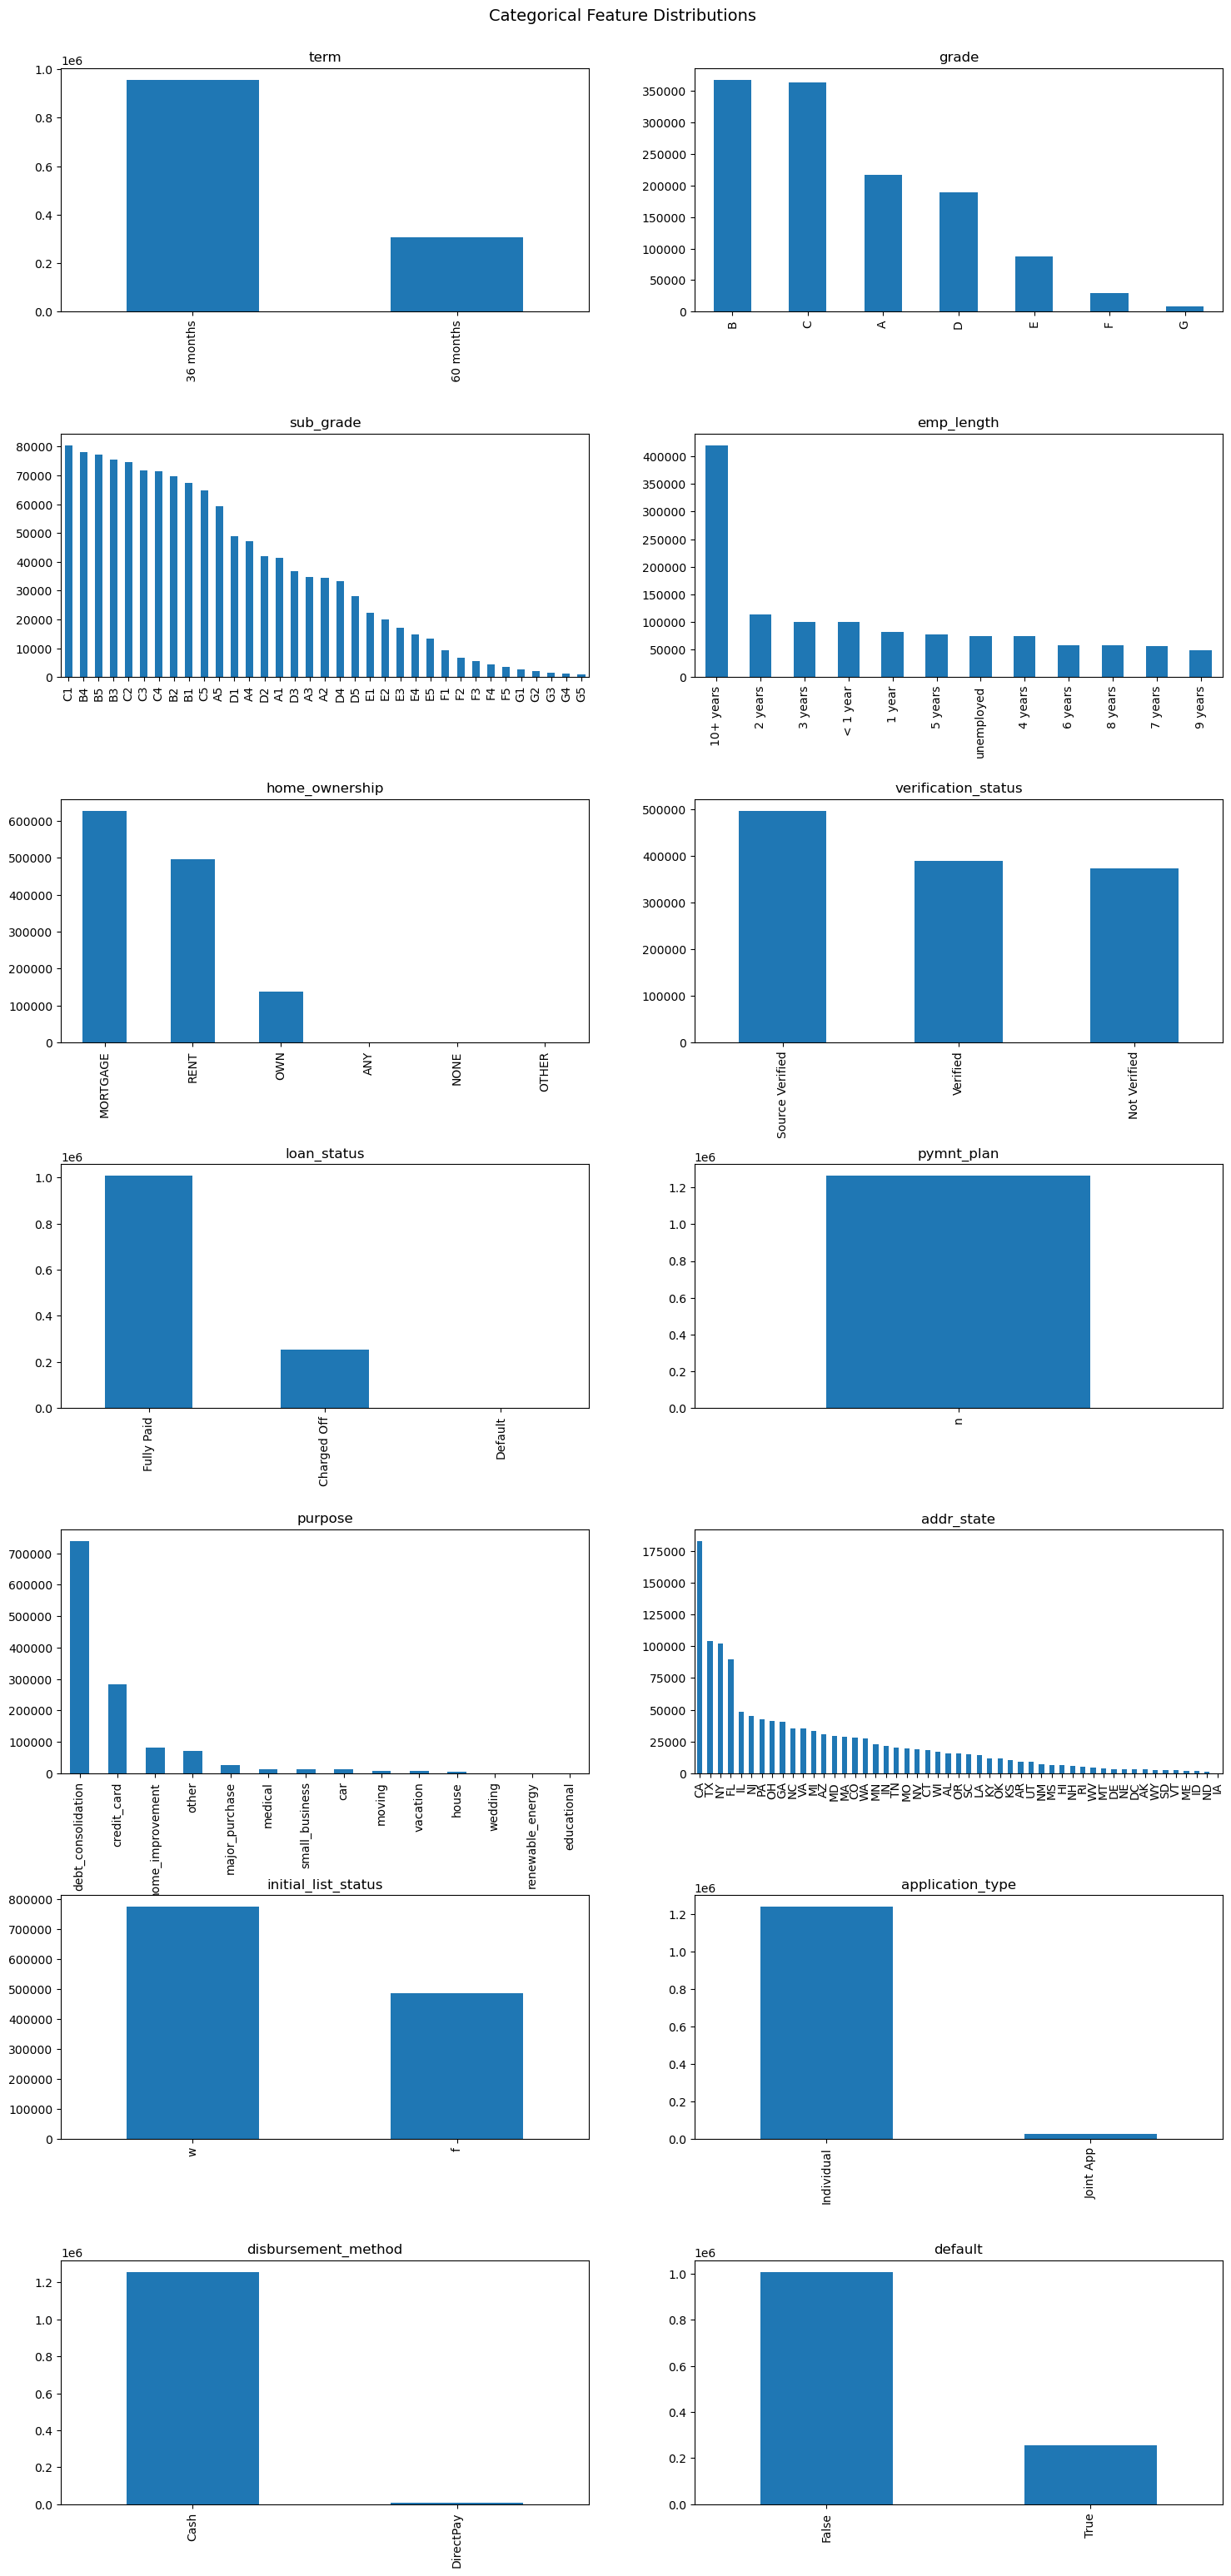

In [3]:
cat_feat = clean_loans_df.select_dtypes('object').columns.values

fig, axs = plt.subplots(nrows=7, ncols=2, figsize=(18, 38))
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Categorical Feature Distributions", fontsize=14, y=0.899)

for i, ax in zip(cat_feat, axs.ravel()):
    clean_loans_df[i].value_counts().plot(kind='bar', ax=ax, xlabel='')
    ax.set_title(i)

**Dropping loan_status and pymnt_plan:**

'loan_status' is now reflected in 'default' and 'pymnt_plan' is now a constant

In [4]:
clean_loans_df = clean_loans_df.drop(['loan_status', 'pymnt_plan'], axis=1)

**Dealing with near-empty levels:**

From below, can see that even though they looked empty on plots, the levels were still represented in the dataset. 

However, since these levels don't seem critical to my analysis and the sample size for these levels is extremely low (potentially making them statistically insignificant), I will remove records with these levels. 

In [5]:
clean_loans_df['purpose'].value_counts()

purpose
debt_consolidation    738159
credit_card           283384
home_improvement       81217
other                  70192
major_purchase         25933
medical                14178
small_business         12422
car                    12258
moving                  8435
vacation                8253
house                   6474
wedding                  862
renewable_energy         773
educational                1
Name: count, dtype: int64

In [6]:
# create a Boolean mask for the rows to remove
mask = clean_loans_df['purpose'] == 'educational'

# select all rows except the ones where purpose == 'education'
clean_loans_df = clean_loans_df[~mask]

In [7]:
clean_loans_df['home_ownership'].value_counts()

home_ownership
MORTGAGE    627698
RENT        496694
OWN         137782
ANY            278
NONE            44
OTHER           44
Name: count, dtype: int64

In [8]:
# create a Boolean mask for the rows to remove
mask1 = clean_loans_df['home_ownership'] == 'NONE'
mask2 = clean_loans_df['home_ownership'] == 'OTHER'

# select all rows except the ones where 'home_ownership' == 'NONE' OR 'OTHER'
clean_loans_df = clean_loans_df[~mask1]
clean_loans_df = clean_loans_df[~mask2]

C:\Users\Jorge\AppData\Local\Temp\ipykernel_13476\1409148635.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clean_loans_df = clean_loans_df[~mask2]


In [9]:
# reset index
clean_loans_df.reset_index(inplace=True)
# drop index column
clean_loans_df = clean_loans_df.drop('index', axis=1)

**Ordinal Variables**

I will replace 'grade', 'sub_grade', and 'emp_length' categories with integer encodings since they seem to be ordinal

In [10]:
sorted_grades = sorted(clean_loans_df['grade'].unique())
grade_dict = dict(zip(sorted_grades, range(len(sorted_grades))))
clean_loans_df['grade'] = clean_loans_df['grade'].map(grade_dict)

sorted_subgrades = sorted(clean_loans_df['sub_grade'].unique())
subgrade_dict = dict(zip(sorted_subgrades, range(len(sorted_subgrades))))
clean_loans_df['sub_grade'] = clean_loans_df['sub_grade'].map(subgrade_dict)

sorted_emp_length = ['unemployed', '< 1 year', '1 year',
                     '2 years', '3 years', '4 years', 
                     '5 years', '6 years', '7 years', 
                     '8 years', '9 years', '10+ years']

emp_length_dict = dict(zip(sorted_emp_length, range(len(sorted_emp_length))))
clean_loans_df['emp_length'] = clean_loans_df['emp_length'].map(emp_length_dict)

**Plotting Select Variables vs. Default Status**

As this dataset has many features, I will plot some select variables that seem like they may be significant vs. the target variable (based on domain knowledge and intuition)

These will be:
* loan_amnt
* annual_inc
* int_rate
* fico_range_low or fico_range_high
* grade
* subgrade
* issue_d

**Notes on Boxplots Below:**
* larger loans are slightly more likely to default on average
* on average, defaulted loans have borrowers with slighlty lower annual incomes
* loans with high interest rates are more likely to default (this seems to be the most significant)
* borrowers with higher FICO scores are less likely to default

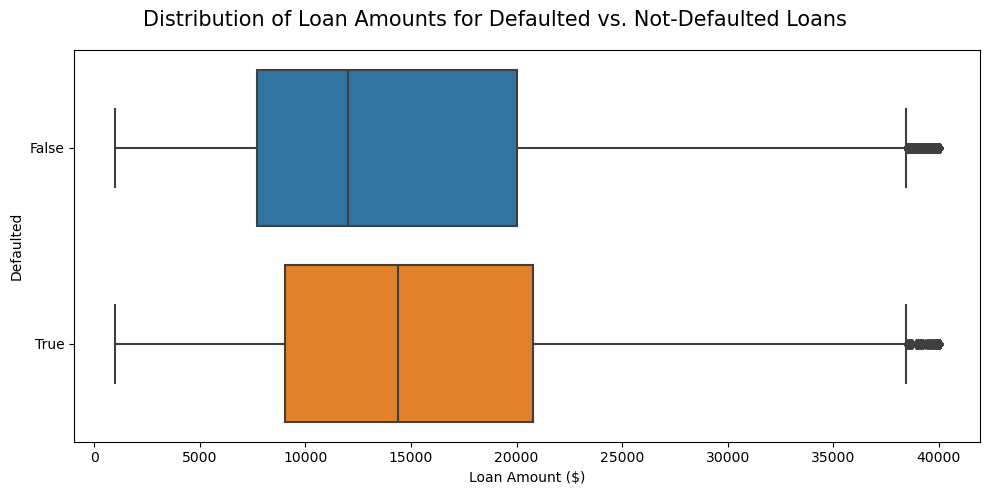

In [11]:
plt.subplots(figsize=(10,5))
plt.suptitle("Distribution of Loan Amounts for Defaulted vs. Not-Defaulted Loans").set_size(15)
sns.boxplot(x="loan_amnt", y="default", data=clean_loans_df).set(xlabel='Loan Amount ($)', ylabel='Defaulted')
plt.tight_layout()

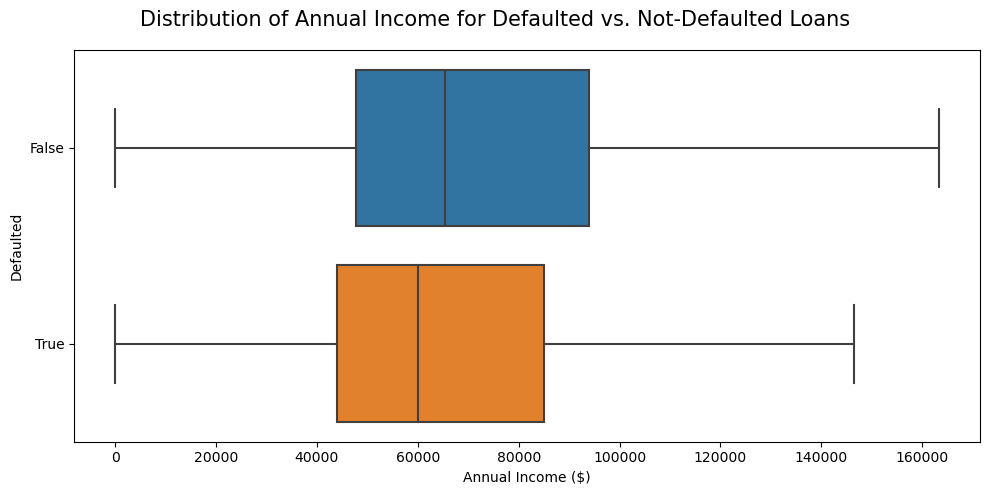

In [12]:
plt.subplots(figsize=(10,5))
plt.suptitle("Distribution of Annual Income for Defaulted vs. Not-Defaulted Loans").set_size(15)

# dropping outlier fliers as a couple super rich people messing with visual
sns.boxplot(x="annual_inc", y="default", data=clean_loans_df, showfliers = False).set(xlabel='Annual Income ($)', ylabel='Defaulted')
plt.tight_layout()

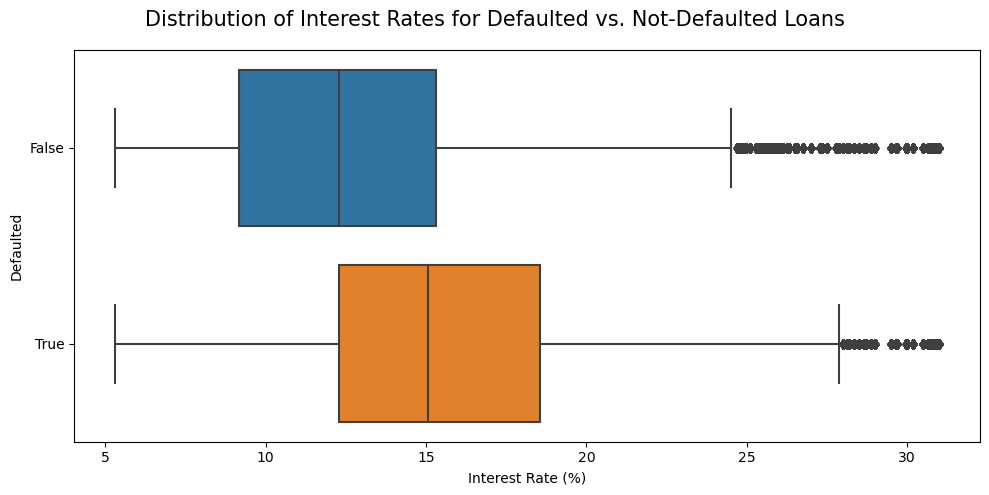

In [13]:
plt.subplots(figsize=(10,5))
plt.suptitle("Distribution of Interest Rates for Defaulted vs. Not-Defaulted Loans").set_size(15)
sns.boxplot(x="int_rate", y="default", data=clean_loans_df).set(xlabel='Interest Rate (%)', ylabel='Defaulted')
plt.tight_layout()

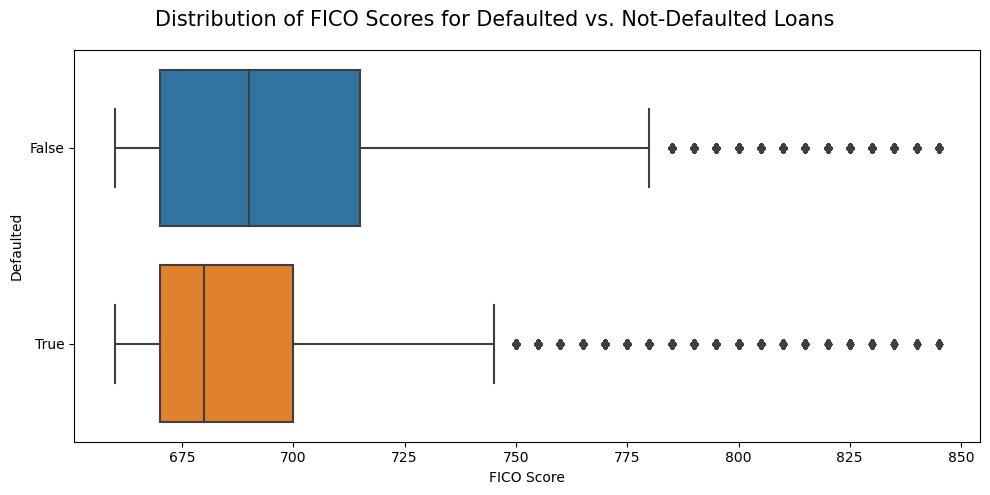

In [14]:
plt.subplots(figsize=(10,5))
plt.suptitle("Distribution of FICO Scores for Defaulted vs. Not-Defaulted Loans").set_size(15)
sns.boxplot(x="fico_range_low", y="default", data=clean_loans_df).set(xlabel='FICO Score', ylabel='Defaulted')
plt.tight_layout()

**Notes on Grade vs %Defaulted Plots Below:**

* The higher the number the worse the grade (A=0, B=1, C=2, etc.)
* The worse the grade, the more likely the borrower will default. Seems like they do a good job grading their loans.
* From the lending club website https://www.lendingclub.com/public/investing-education-center.action#:~:text=Lending%20Club%20assigns%20a%20grade,and%20lower%20volatility%20in%20returns .: 
  * Lending Club assigns a grade (from A to D) to each loan based on borrower credit quality and underlying risk.
  * The lowest interest rates are assigned to the least risky grades, which reflect the potentially lower loss rates (lower rate of charged off loans) and lower volatility in returns.

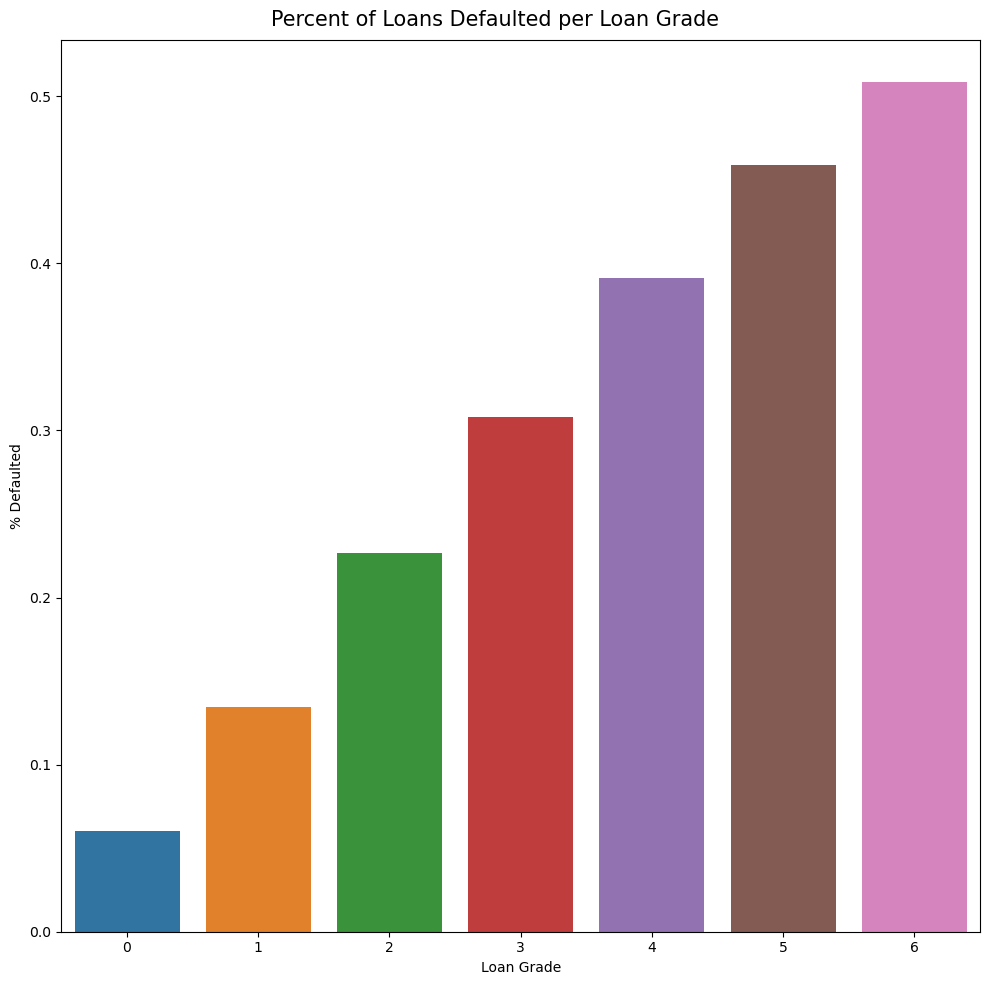

In [15]:
# convert back to boolean to calculate mean
clean_loans_df['plot_var'] = clean_loans_df['default'].map({'True':1, 'False':0})

defaults_per_grade = clean_loans_df.groupby('grade').agg({'plot_var': np.mean})

plt.subplots(figsize=(10,10))
plt.suptitle("Percent of Loans Defaulted per Loan Grade").set_size(15)
sns.barplot(x=defaults_per_grade.index, y=defaults_per_grade['plot_var']).set(xlabel='Loan Grade', ylabel='% Defaulted')
plt.tight_layout()

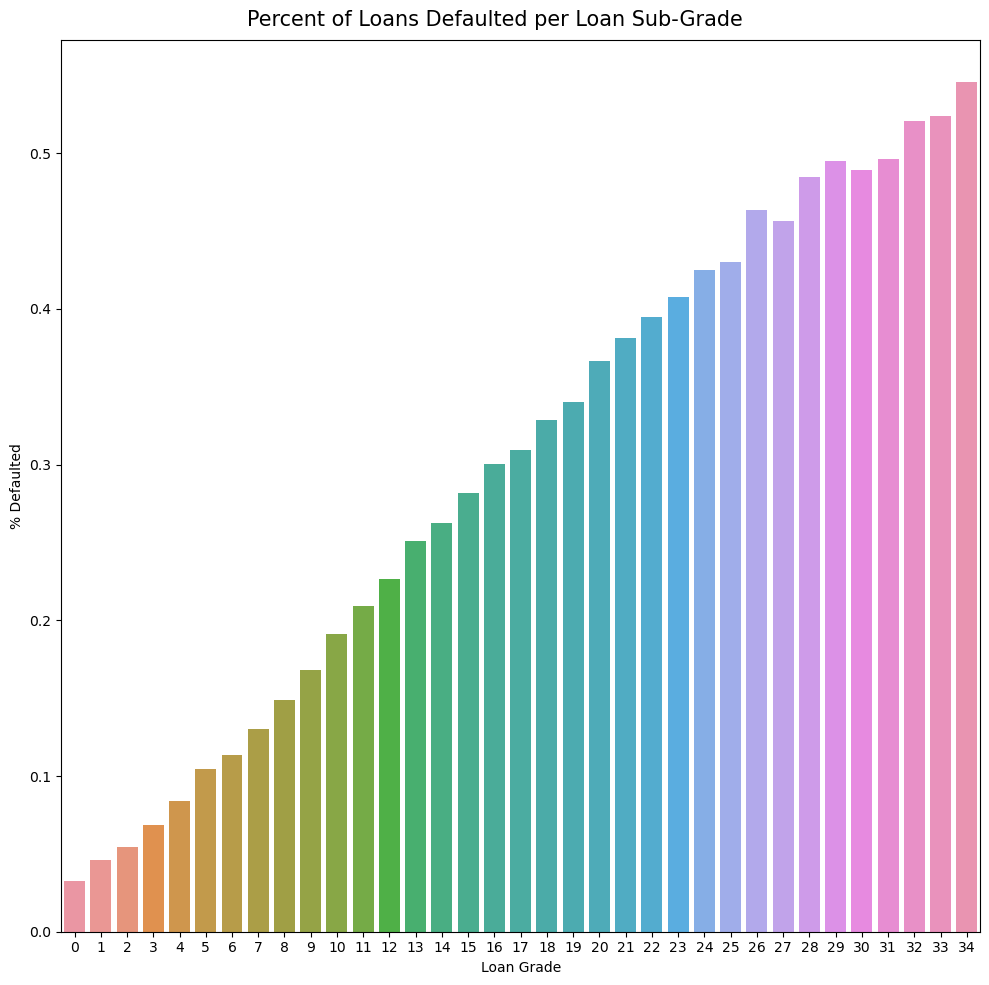

In [16]:
defaults_per_grade = clean_loans_df.groupby('sub_grade').agg({'plot_var': np.mean})

plt.subplots(figsize=(10,10))
plt.suptitle("Percent of Loans Defaulted per Loan Sub-Grade").set_size(15)
sns.barplot(x=defaults_per_grade.index, y=defaults_per_grade['plot_var']).set(xlabel='Loan Grade', ylabel='% Defaulted')
plt.tight_layout()

In [17]:
# drop previously added column that was used for plotting
clean_loans_df = clean_loans_df.drop('plot_var', axis=1)

**Correlation Plot of Numeric Variables:**

From the correlation heatmap below, we can see that there are some highly correlated variables. There are also certain groupings of highly correlated variables, such as many of the "num_..." features seem to be highly correlated.

In [18]:
num_feat = clean_loans_df.select_dtypes(['float64', 'int64']).columns.values
corr_matrix = clean_loans_df[num_feat].corr(method="pearson").round(2)

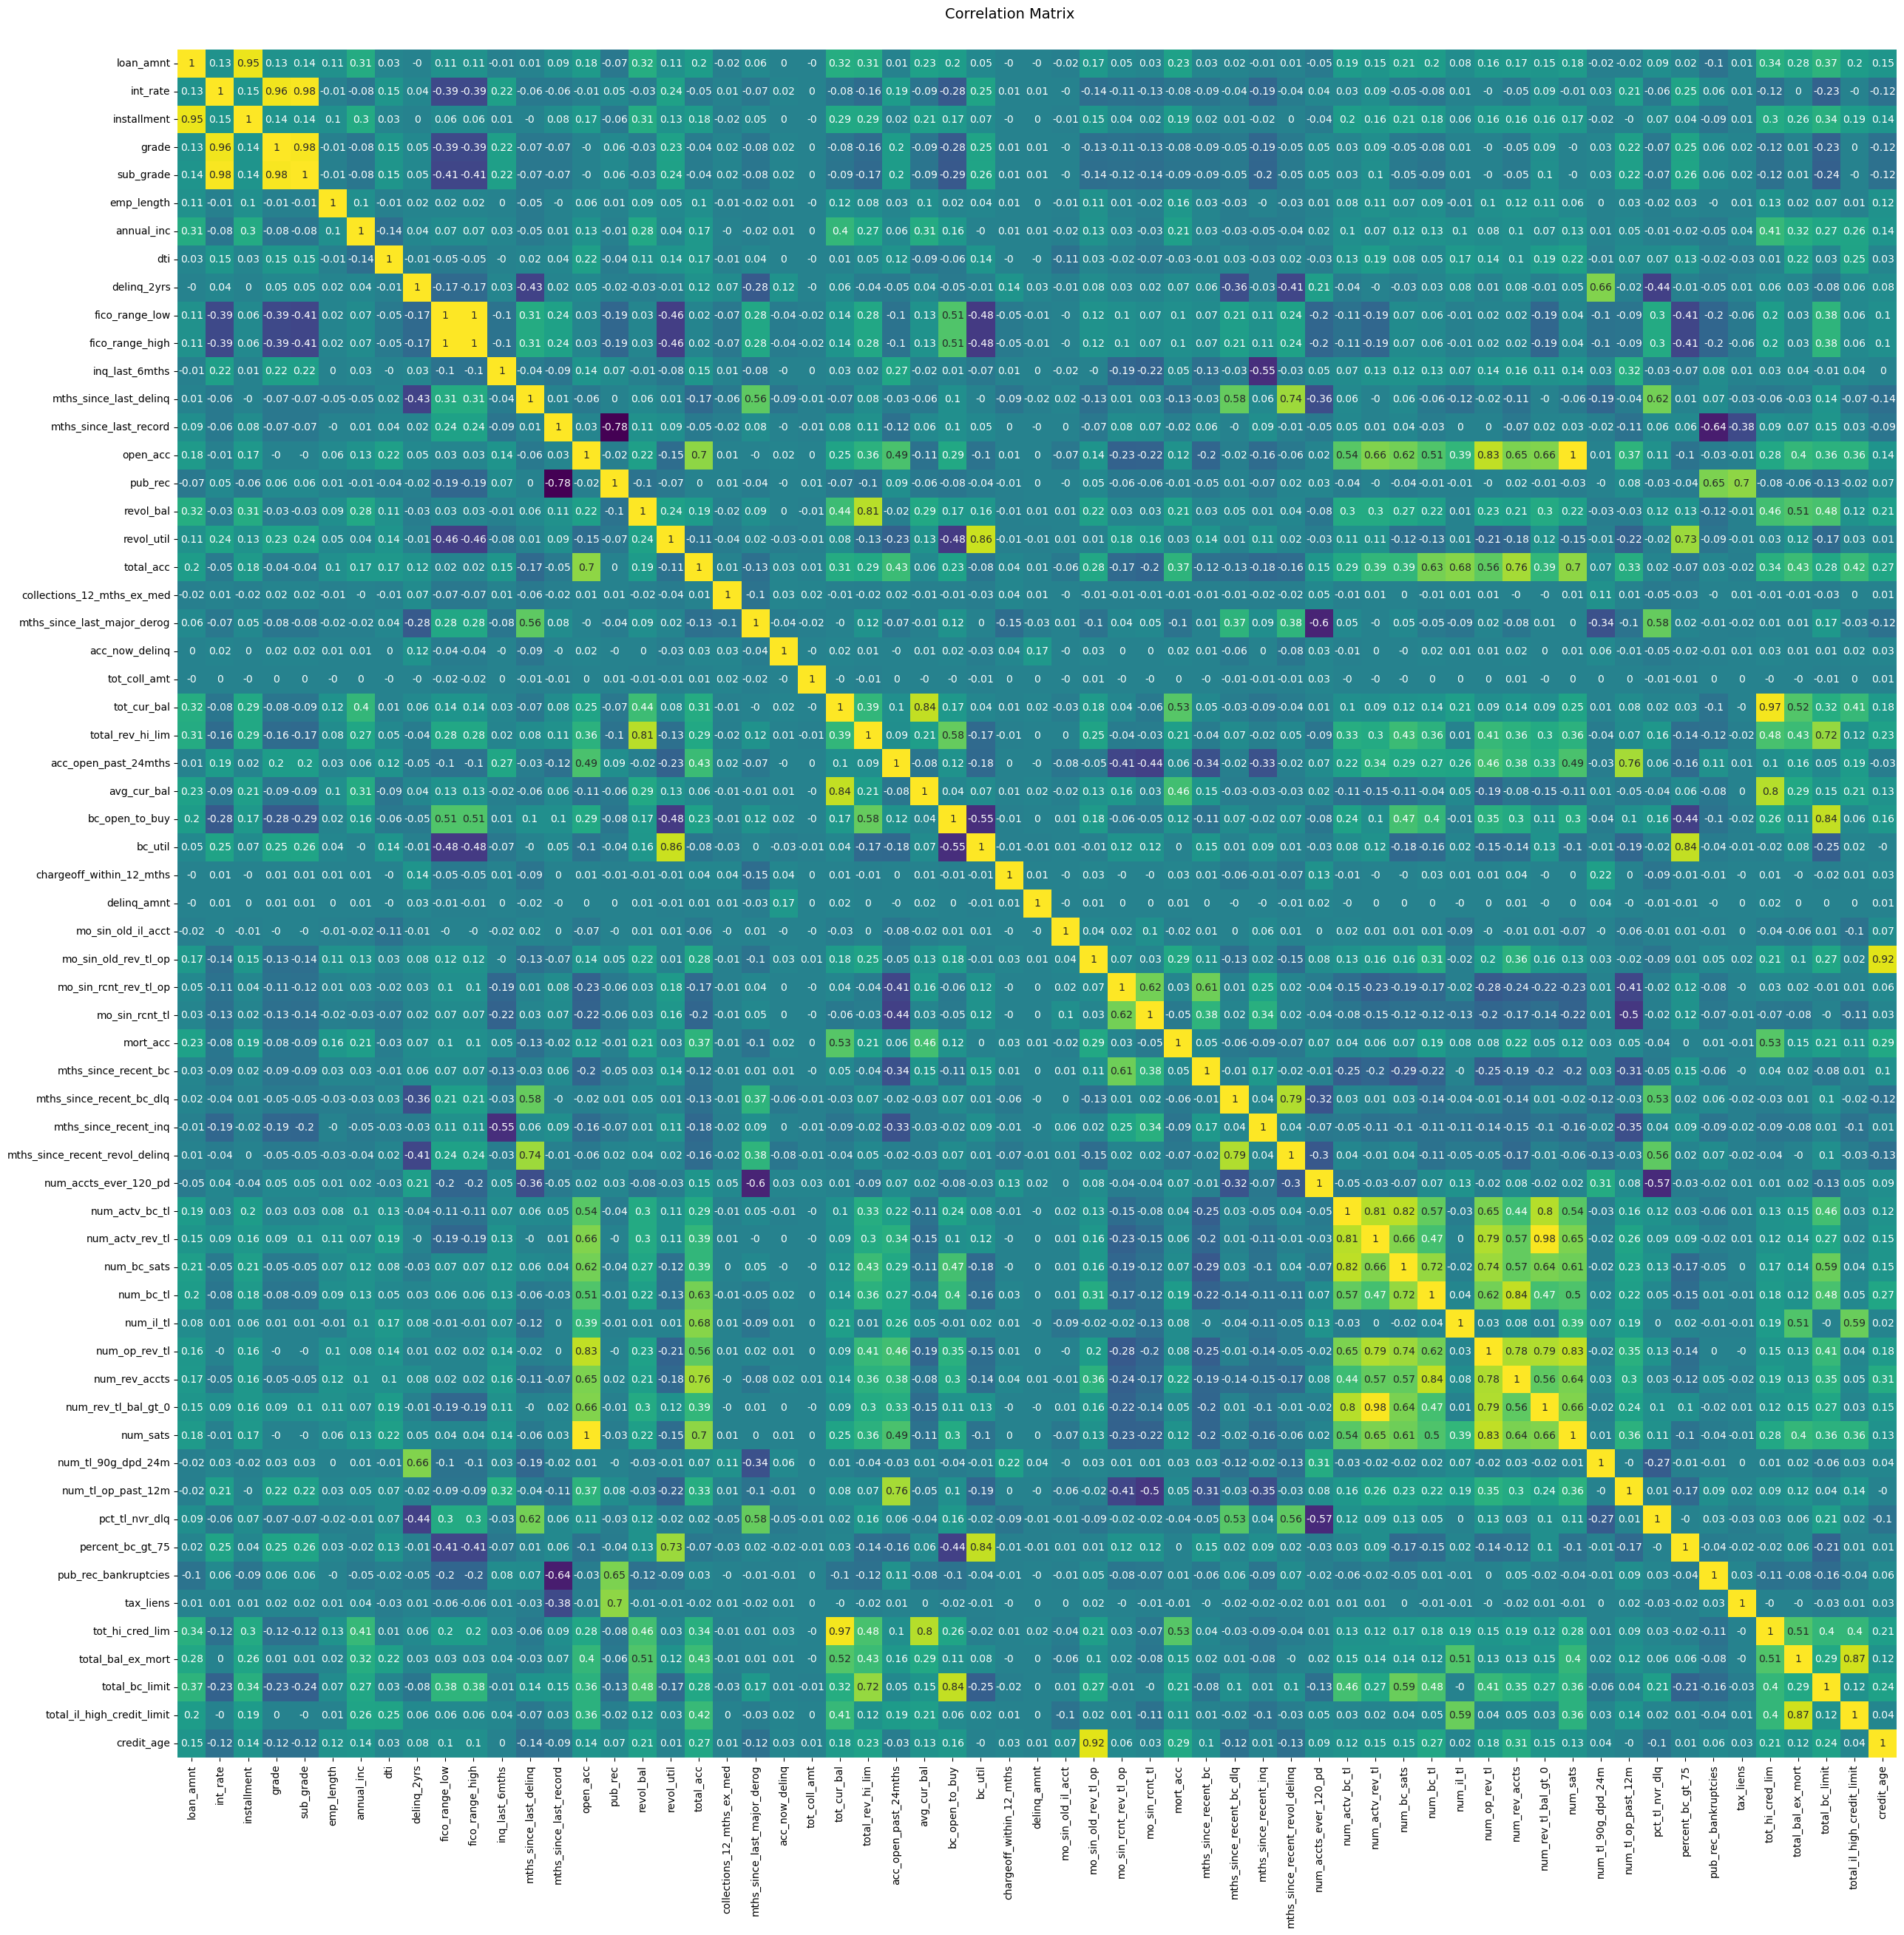

In [19]:
plt.subplots(figsize=(30,30))
plt.suptitle("Correlation Matrix", fontsize=14, y=0.899)
sns.heatmap(corr_matrix, annot=True, cmap="viridis", cbar=False)
plt.show()

**First I will try to remove the features that are obviously dependent on another feature or that carry the same or close enough information:**
* int_rate (dependant on sub_grade, as scene from lending club website)
* loan_amount (close enough to installment)
* grade (same info as grade but less granular)
* num_tl_90g_dpd_24m (same as delinq_2yrs, just 90+ days delinquent instead of 30)
* fico_range_high (same info as fico range low)
* total_rev_hi_lim (total revolving credit carries roughly same info as total_revolving balance. I'll keep revol_bal)
* num_tl_op_past_12m (accounts open in past 12 months; highly correlated with acc_open_past_24mths)
* avg_cur_bal (similar to total_cur_bal)
* tot_hi_cred_lim (similar to total_cur_bal)
* bc_util (info also in revol_util which semms to be calculated using bc_util and percent_bc_gt_75)
* percent_bc_gt_75 (info also in revol_util which semms to be calculated using bc_util and percent_bc_gt_75)
* mths_since_recent_revol_delinq (similar to mths_sin_rcnt_bc_dlq (revolving delinquency and bankcard delinquency)
* num_rev_accts (num revolving accountys close enough to number of open accounts)
* num_sats (num satisfactory accounts close enough to number of open accounts)
* num_rev_tl_bal_gt_0 (number of revolving trades with balance greater than 0 close enough to number of open accounts)
* total_il_high_credit_limit (total credit balance; correlated to total balance excluding mortgage, and keeping mortgage info might be usefult)
* total_bc_limit (similar to average current balance of all accounts (bc_open_to_buy)
* num_bc_tl (number of bankcard accounts, similar to number of satisfactory bankcard accounts (num_bc_sats)
* num_op_rev_tl (number of open revolving accounts, similar to number of satisfactory bankcard accounts (num_bc_sats)
* mths_since_last_record (highly correlated to number of derogatory records (pub_rec) probably because there were many nulls, and that feature seems more useful)
* pub_rec_bankruptcies (highly correlated to pub_rec just one type of pub_rec/more granular)
* tax_liens (just another type of pub_rec)
* total_acc (number of credit lines currently in the borrower's credit file, similar to open_acc (number of open accounts in credit file)
* num_actv_rev_tl (number of active revolving trades, correlated to a few other similar vars like active cards and accounts)
* num_bc_sats (number of satisfactory cards similar to number of active card trades)
* mo_sin_old_rev_tl_op (very similar info to credit_age)

**Dropping Highly Correlated Variables and Plotting New Matrix:**

In [20]:
# Dropping selected features
clean_loans_df = clean_loans_df.drop(['loan_amnt', 'int_rate', 'grade',
                                        'num_tl_90g_dpd_24m', 'fico_range_high',
                                        'total_rev_hi_lim',
                                        'num_tl_op_past_12m', 'avg_cur_bal',
                                        'tot_hi_cred_lim', 'bc_util',
                                        'percent_bc_gt_75', 'mths_since_recent_revol_delinq',
                                        'num_rev_accts', 'num_sats',
                                        'num_rev_tl_bal_gt_0', 'total_il_high_credit_limit',
                                        'total_bc_limit', 'num_bc_tl', 
                                        'num_op_rev_tl', 'mths_since_last_record', 
                                        'pub_rec_bankruptcies','tax_liens',
                                        'total_acc', 'num_actv_rev_tl',
                                        'num_bc_sats', 'mo_sin_old_rev_tl_op'], axis=1)

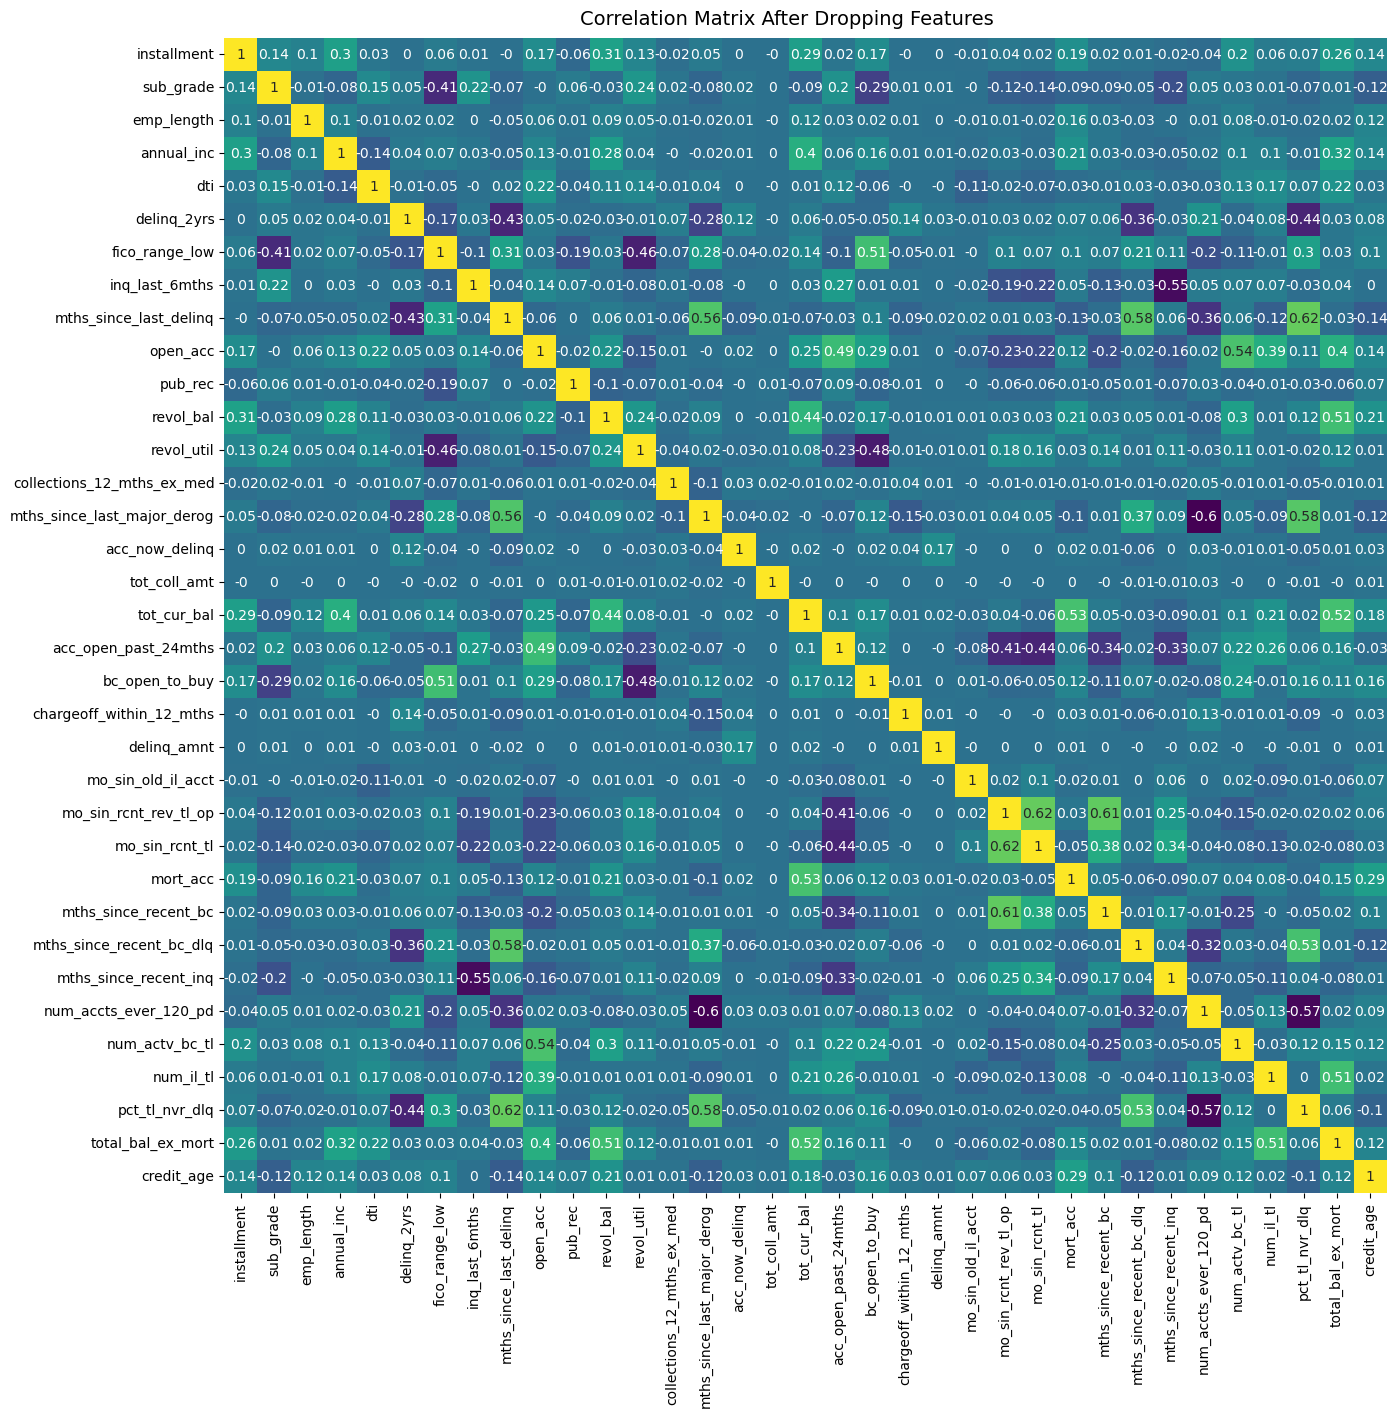

In [21]:
num_feat = clean_loans_df.select_dtypes(['float64', 'int64']).columns.values
corr_matrix = clean_loans_df[num_feat].corr(method="pearson").round(2)

plt.subplots(figsize=(15,15))
plt.suptitle("Correlation Matrix After Dropping Features", fontsize=14, y=0.899)
sns.heatmap(corr_matrix, annot=True, cmap="viridis", cbar=False)
plt.show()

**Saving clean dataset for analysis**:

In [22]:
clean_loans_df.to_pickle('cleaner_loans_df.pkl') # saving data after removing highly correlated variables